# Intro
## Questions:
- Will voting differ based on age, sex, education, and income?
- Is the data we have statistically significant?
- What importance do the features have, and which can we focus on?

Limitations:
- This is a sample taken before the election
- There are only 2700 who have taken the survey, out of 7,429,404 registered voters

## Data

chile_voting_intentions_1988.csv contains the following columns:

region
- A factor with levels: C, Central; M, Metropolitan Santiago area; N, North; S, South; SA, city of Santiago.

population
- Population size of respondent's community.

sex
- A factor with levels: F, female; M, male.

age
- in years.

education
- A factor with levels (note: out of order): P, Primary; PS, Post-secondary; S, Secondary.

income
- Monthly income, in Pesos.

statusquo
- Scale of support for the status-quo.

vote
- a factor with levels: A, will abstain; N, will vote no (against Pinochet); U, undecided; Y, will vote yes (for Pinochet).

# Config and setup

In [550]:
# Starting off with importing important tools and reading in the data we will be working with

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [551]:
sns.set_palette("rocket")
df = pd.read_csv('chile_voting_intentions_1988.csv')
df.head()

,region,population,sex,age,education,income,statusquo,vote
0,N,175000,M,65.0,P,35000.0,1.00820,Y
1,N,175000,M,29.0,PS,7500.0,-1.29617,N
2,N,175000,F,38.0,P,15000.0,1.23072,Y
3,N,175000,F,49.0,P,35000.0,-1.03163,N
4,N,175000,F,23.0,S,35000.0,-1.10496,N


In [552]:
# Reordering educational categories
df.education = pd.Categorical(df.education, ["P", "S", "PS"])
df.education.value_counts()

education
S     1120
P     1107
PS     462
Name: count, dtype: int64

In [553]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   region      2700 non-null   object  
 1   population  2700 non-null   int64   
 2   sex         2700 non-null   object  
 3   age         2699 non-null   float64 
 4   education   2689 non-null   category
 5   income      2602 non-null   float64 
 6   statusquo   2683 non-null   float64 
 7   vote        2532 non-null   object  
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 150.6+ KB


In [554]:
df.describe()

,population,age,income,statusquo
count,2700.000000,2699.000000,2602.000000,2.683000e+03
mean,152222.222222,38.548722,33875.864719,-1.118151e-08
std,102198.039602,14.756415,39502.867120,1.000186e+00
min,3750.000000,18.000000,2500.000000,-1.803010e+00
25%,25000.000000,26.000000,7500.000000,-1.002235e+00
50%,175000.000000,36.000000,15000.000000,-4.558000e-02
75%,250000.000000,49.000000,35000.000000,9.685750e-01
max,250000.000000,70.000000,200000.000000,2.048590e+00


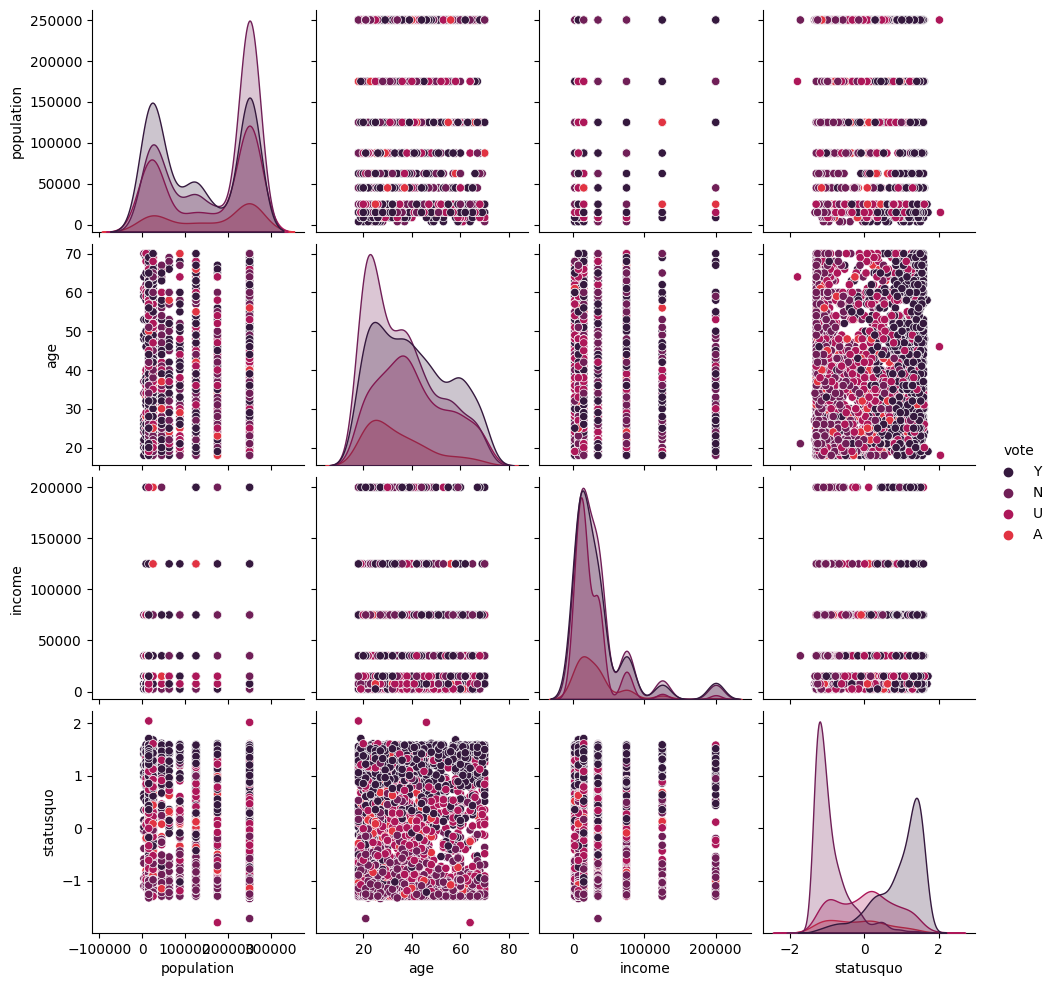

In [555]:
sns.pairplot(df,hue='vote')

In [556]:
# Define the features and target variables for our models
FEATURES = ["region","sex","age","income","statusquo", "population"]
TARGET = ['vote']

In [557]:
# Assign each data point an age group to make further comparisons
bins = [0, 30, 44, 57, 100]
group_names = ['18-30','31-44','45-57','58-70']
df['age_group'] = pd.cut(df['age'], bins, labels=group_names)

## Overview of voter distrubution

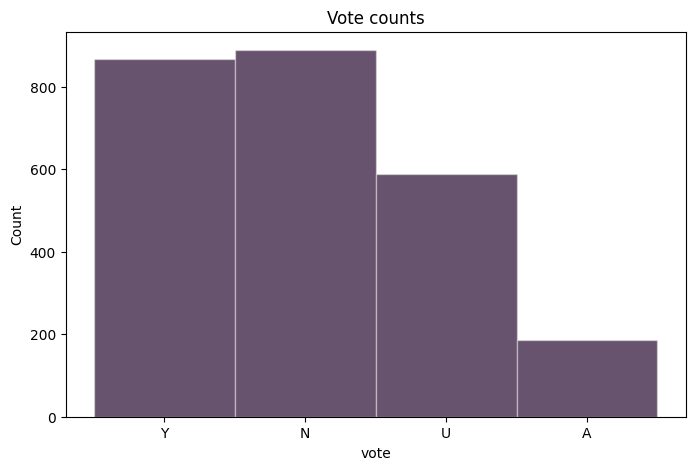

In [565]:
# Get vote distrubution
plt.figure(figsize=(8,5))
sns.histplot(data=df.vote, edgecolor=(1, 1, 1, .4))\
    .set_title('Vote counts')
plt.show()

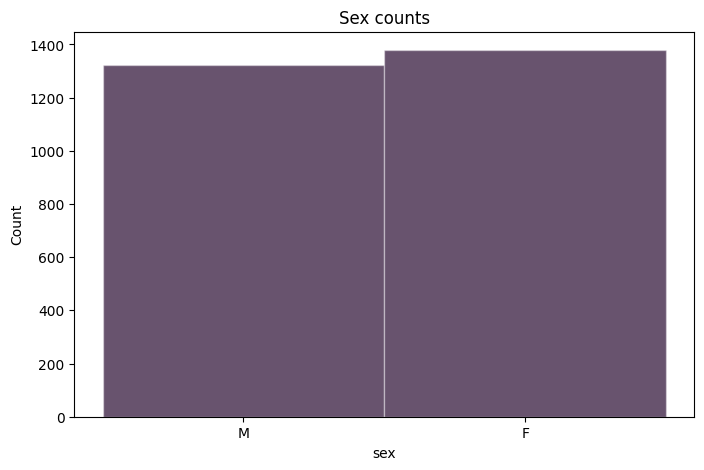

In [566]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.sex, edgecolor=(1, 1, 1, .4))\
    .set_title('Sex counts')
plt.show()

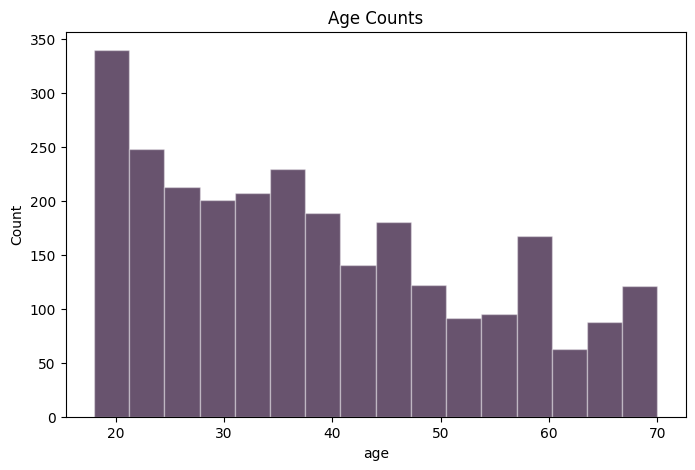

In [567]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.age, edgecolor=(1, 1, 1, .4))\
    .set_title('Age Counts')
plt.show()

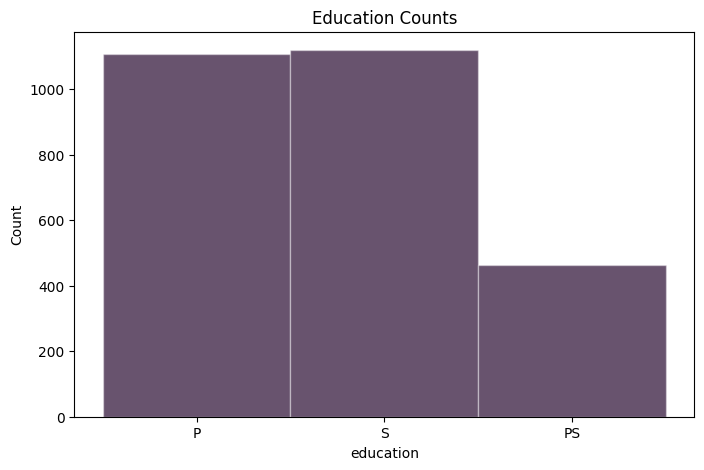

In [568]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.sort_values('education').education, edgecolor=(1, 1, 1, .4))\
    .set_title('Education Counts')
plt.show()

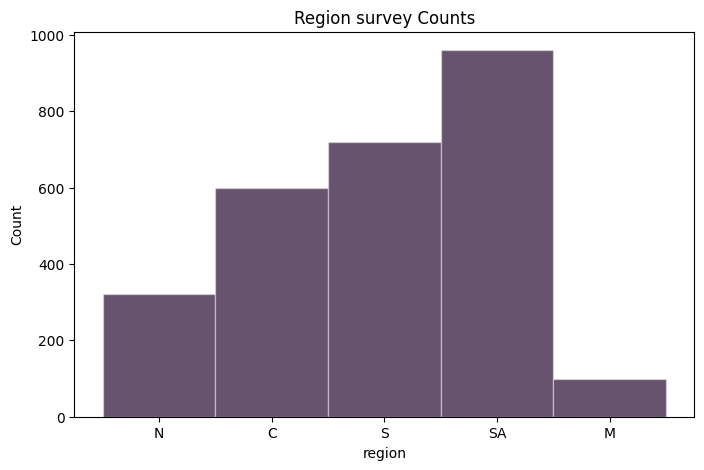

In [569]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.region, edgecolor=(1, 1, 1, .4))\
    .set_title('Region survey Counts')
plt.show()

In [570]:
df.income.value_counts().sort_index(ascending=True)

income
2500.0      160
7500.0      494
15000.0     768
35000.0     747
75000.0     269
125000.0     88
200000.0     76
Name: count, dtype: int64

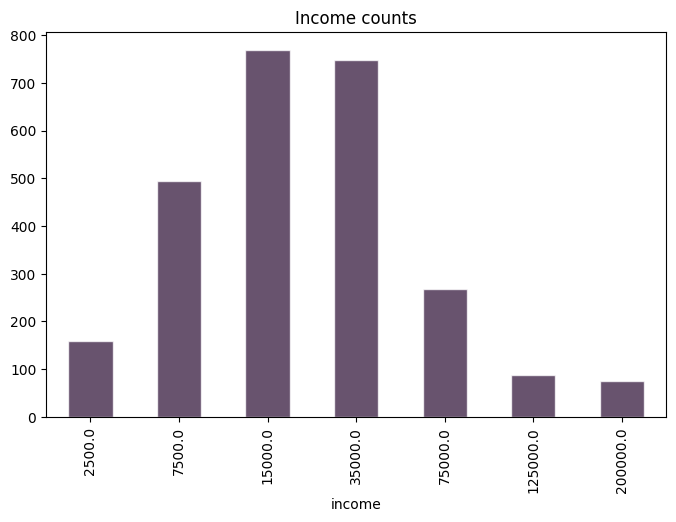

In [571]:
fig = plt.figure(figsize=(8,5))
dt = df.income.value_counts().sort_index(ascending=True).plot(kind='bar', alpha=.75, edgecolor=(1, 1, 1, .4))\
    .set_title('Income counts')
plt.show()

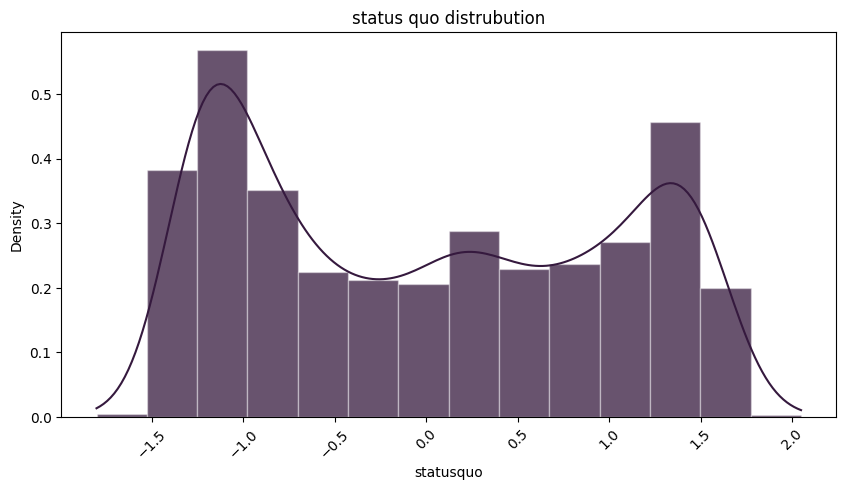

In [572]:
fig = plt.figure(figsize=(10,5))
sns.histplot(df.statusquo, kde=True,stat="density", alpha=.75, edgecolor=(1, 1, 1, .4))\
    .set_title('status quo distrubution')
plt.xticks(rotation=45)
plt.show()

# Statistical significance

## Chi squared on voting results
Null hypothesis: Voter intentions are the same for all choices

Alternative hypothesis: Voter intention is NOT the same for all choices

In [558]:
observed = df.vote.value_counts()

dict = {'Y' : .25,
        'N' : .25,
        'U' : .25,
        'A': .25}
   
expected = pd.Series(dict)* np.sum(observed)
stats.chisquare(f_obs = observed, f_exp = expected)

Power_divergenceResult(statistic=508.21800947867297, pvalue=7.900936336731479e-110)

In [559]:
# Format categorical variables so we can use them in our models
le = LabelEncoder()

temp = df.copy().dropna()
temp.sex = le.fit_transform(temp.sex)
temp.region = le.fit_transform(temp.region)
temp.vote = le.fit_transform(temp.vote)

X_train = temp[FEATURES]
y_train = temp[TARGET]

## P_values

In [560]:
p_values = pd.DataFrame(columns=['feature','p_value'])
for fi in df[FEATURES]:
    xt = pd.crosstab(df.vote, df[fi])
    p = stats.chi2_contingency(xt).pvalue
    new_row = {'feature': fi, 'p_value': p}
    p_values.loc[len(p_values)] = new_row

# We want p lower than 5%
alpha = 0.05
p_values['reject H0'] = p_values.p_value < alpha
p_values

,feature,p_value,reject H0
0,region,4.278000e-09,True
1,sex,3.156384e-15,True
2,age,1.471725e-03,True
3,income,2.364306e-04,True
4,statusquo,1.877245e-23,True
5,population,2.935134e-12,True


We can reject the null hypothesis for all features and accept the alternative. Since the p value is lower than our alpha we can conclude that the features are statisticaly significant

# Feature Selection

In [561]:
# Define a reusable plot function since we will be comparing multiple models
def disp_fi(feature_names, feature_importances):
    plt.figure(figsize=(8,5))
    data = list(zip(feature_names, feature_importances))
    fi = pd.DataFrame(data, columns =['feature', 'importance'])
    
    sns.barplot(data=fi, x='importance', y=feature_names, order=fi.sort_values('importance', ascending=False).feature)
    plt.show()

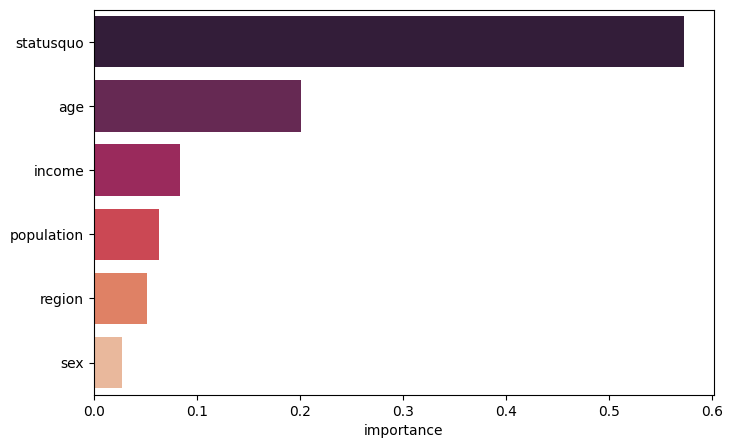

In [562]:
rfc = RandomForestClassifier()
rfc.fit(X=X_train, y=y_train.values.ravel())

# plot feature importance
disp_fi(rfc.feature_names_in_, rfc.feature_importances_)

## XGBClassifier

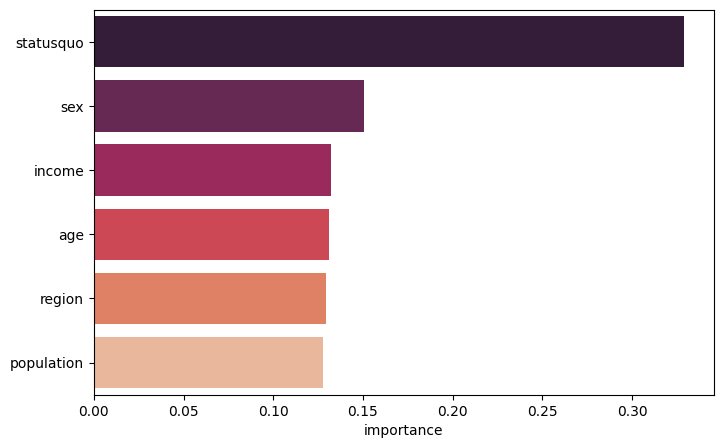

In [563]:
xgb_clf = xgb.XGBClassifier(objective='reg:logistic', booster='gbtree')
xgb_clf.fit(X_train, y_train)

disp_fi(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)

## Average Feature Importance

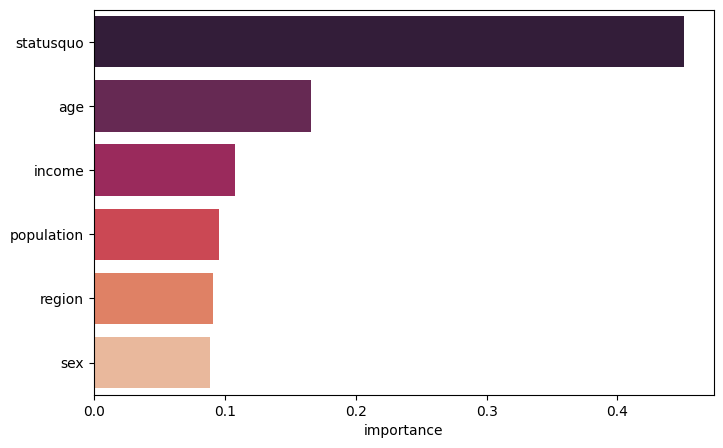

In [564]:
# Calculate average feature importance
avg_fi_value = (xgb_clf.feature_importances_ + rfc.feature_importances_) / 2

# Display average feature importance
disp_fi(xgb_clf.feature_names_in_, avg_fi_value)

We can see that statusquo is the most important feature. Sex is the second and the rest are about equally important at around 10% each.

Since there are differences in the importances between our two models, so we have taken the average importance. The reason for these differences can be explained by the models methodology.

We will focus on statusquo and sex for now.

# Analyze

The vote is of statistical significance. With a P value of 7.900936336731479e-110, we can reject the null hypothesis and accept the alternative.

## Status quo of different voter groups
### Status quo by vote

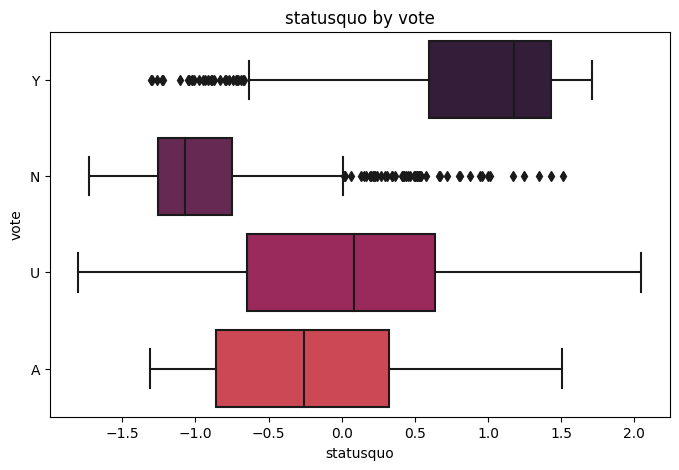

In [587]:
col2 = df.statusquo
col1 = df.vote

fig = plt.figure(figsize=(8,5))
sns.boxplot(x=col2,y=col1)
plt.title(f'{col2.name} by {col1.name}')
plt.xticks(rotation=0)
plt.show()

In [653]:
xt = pd.crosstab(df.statusquo, df.vote)
p = stats.chi2_contingency(xt).pvalue
p

1.8772450866292037e-23

P<0.05. We reject the null hypothesis, it is has statistic significance.
 
We can spot some pattern in the status quo to voting choise:
- Voters with a low status quo generaly vote no
- Voters with a high status quo generaly vote yes
- voters with a status quo value close to 0 are unsure or will abstain

### Status quo by sex

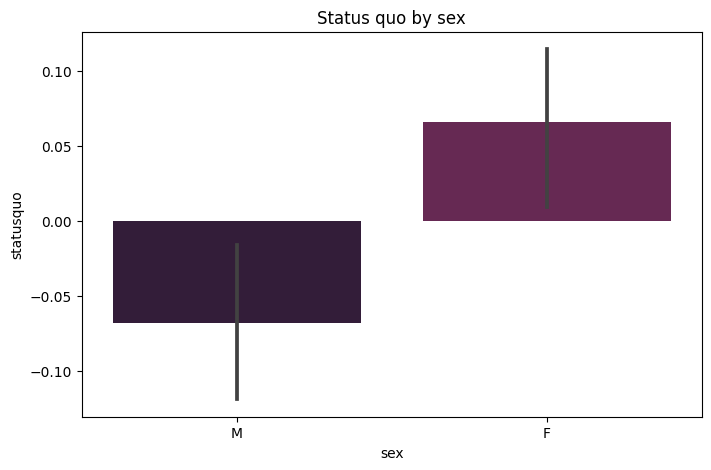

In [589]:
fig = plt.figure(figsize=(8,5))
sns.barplot(data=df, x="sex", y="statusquo") \
    .set(title='Status quo by sex')
plt.show()

At a first glance we can see a clear pattern of high status quo for women and a low status quo for men. But let's run a quick chi2 test to see if this is an important observation

In [644]:
xt = pd.crosstab(df.statusquo, df.sex)
p = stats.chi2_contingency(xt).pvalue
p

0.28630780043300746

With a p value of 0.28(28%), we fail to reject the null hypothesis. 

### Region status quo

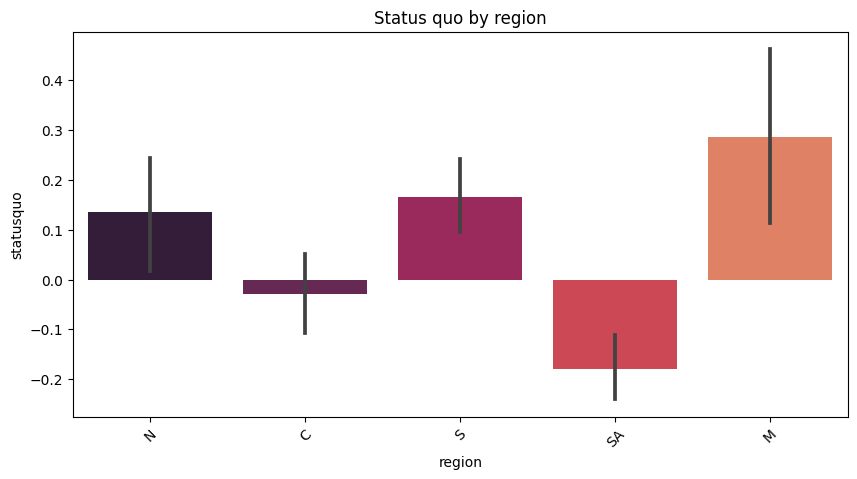

In [591]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="region", y="statusquo") \
    .set(title='Status quo by region')
plt.xticks(rotation=45)
plt.show()

We can see a difference of status quo between regions. We'll run a quick chi2 test to see if this is an important observation

In [645]:
xt = pd.crosstab(df.statusquo, df.region)
p = stats.chi2_contingency(xt).pvalue
p

0.007846233131436547

The p value is 0.0078 (0.78%), we fail to reject the null hypothesis and accept the alternative. This is a statisticaly significant observation

### Education status quo

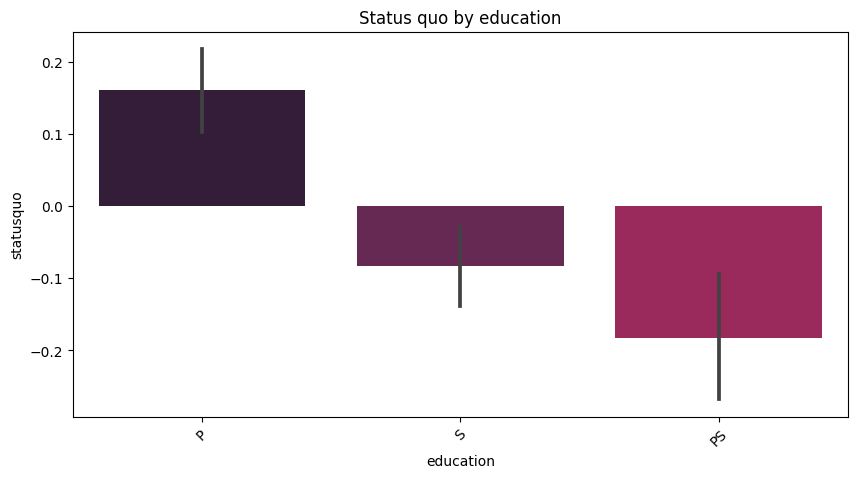

In [593]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x=df.education.sort_values(), y="statusquo") \
    .set(title='Status quo by education')
plt.xticks(rotation=45)
plt.show()

It looks like there is a difference between education levels and status quo. A Chi2 test will tell us if it is significant 

In [646]:
xt = pd.crosstab(df.statusquo, df.education)
p = stats.chi2_contingency(xt).pvalue
p

0.5849844084778982

We fail to reject the null hypothesis with a p value of 0.58(58%)

### Age status quo

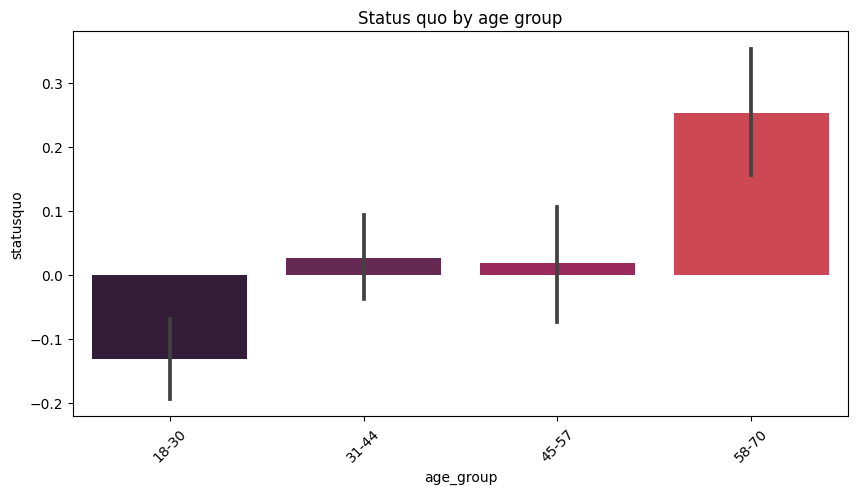

In [613]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x=df.age_group, y="statusquo") \
    .set(title='Status quo by age group')
plt.xticks(rotation=45)
plt.show()

In [650]:
xt = pd.crosstab(df.statusquo, df.age_group)
p = stats.chi2_contingency(xt).pvalue
p

0.6811389309039335

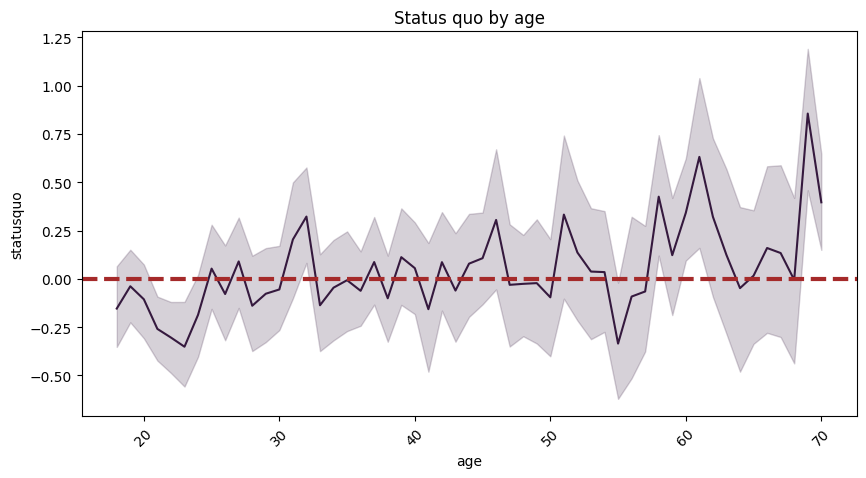

In [622]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=df, x="age", y="statusquo")\
    .set(title='Status quo by age')
plt.axhline(linewidth=3, color='brown', linestyle='--')
plt.xticks(rotation=45)
plt.show()

In [651]:
xt = pd.crosstab(df.statusquo, df.age)
p = stats.chi2_contingency(xt).pvalue
p

0.9980550906105736

## Age
Characteristicts and patterns of different age groups

In [623]:
def plot_voting_dist(col1, col2):
    fig = plt.figure(figsize=(8,5))
    cross_tab_prop = pd.crosstab(index=col1, columns=col2, normalize="index")
    cross_tab_prop.plot(kind='bar', stacked=True)
    plt.title(f'{col2.name} by {col1.name}')
    plt.xticks(rotation=0)
    plt.show()

### Age and sex

<Figure size 800x500 with 0 Axes>

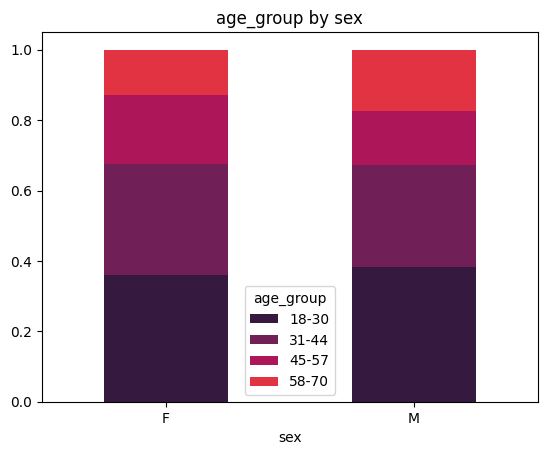

In [641]:
plot_voting_dist(df.sex, df.age_group)

It's very even in ages between genders/sexes

### Age in different regions

<Figure size 800x500 with 0 Axes>

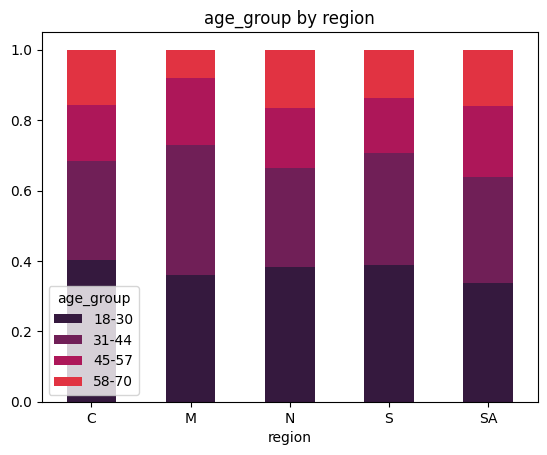

In [655]:
plot_voting_dist(df.region, df.age_group)

### Age group education

<Figure size 800x500 with 0 Axes>

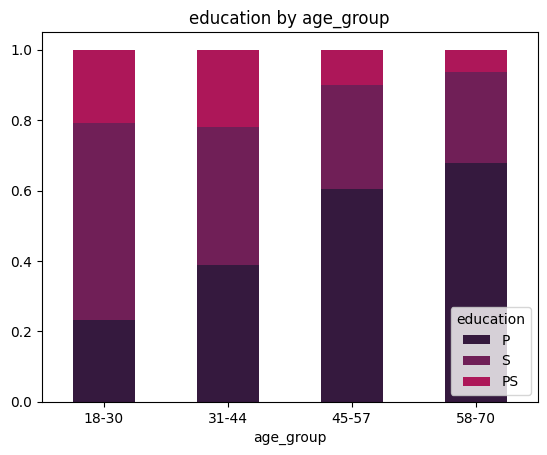

In [632]:
plot_voting_dist(df.age_group, df.education)

In [652]:
xt = pd.crosstab(df.education, df.age_group)
p = stats.chi2_contingency(xt).pvalue
p

8.561614230672493e-71

With a P value so low, we can reject the null hypothesis and accept the alternative. It is a significant insight that we can explore further.

We can see a clear pattern of more education in younger voters. Especially secondary level

### Age group vote

<Figure size 800x500 with 0 Axes>

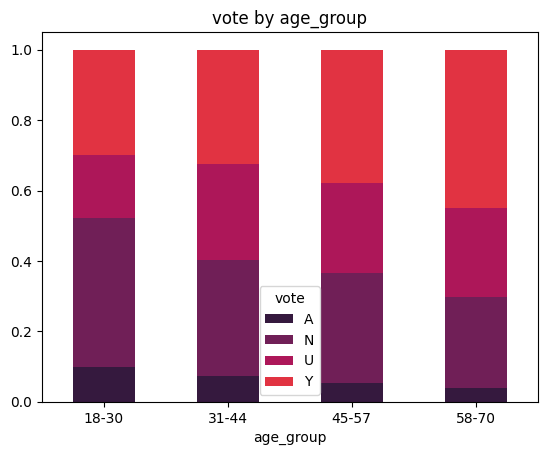

In [633]:
plot_voting_dist(df.age_group, df.vote)

In [656]:
xt = pd.crosstab(df.vote, df.age_group)
p = stats.chi2_contingency(xt).pvalue
p

6.367418369569126e-14

With a P value so low, we can reject the null hypothesis and accept the alternative. It is a significant insight that we can explore further.

# Voting distrubution

<Figure size 800x500 with 0 Axes>

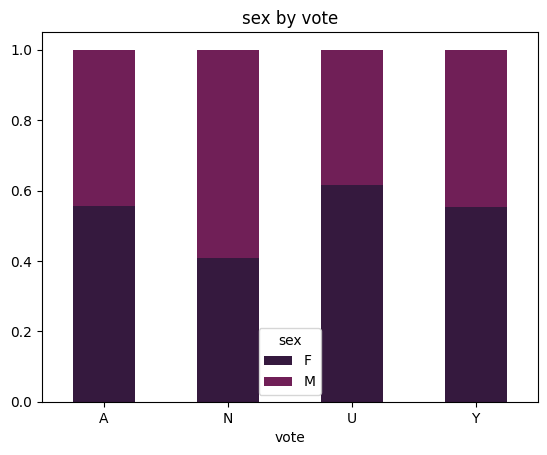

In [634]:
plot_voting_dist(df.vote, df.sex)

<Figure size 800x500 with 0 Axes>

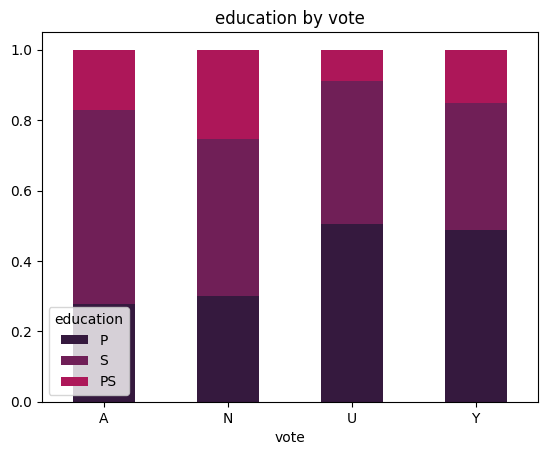

In [635]:
plot_voting_dist(df.vote, df.education)

<Figure size 800x500 with 0 Axes>

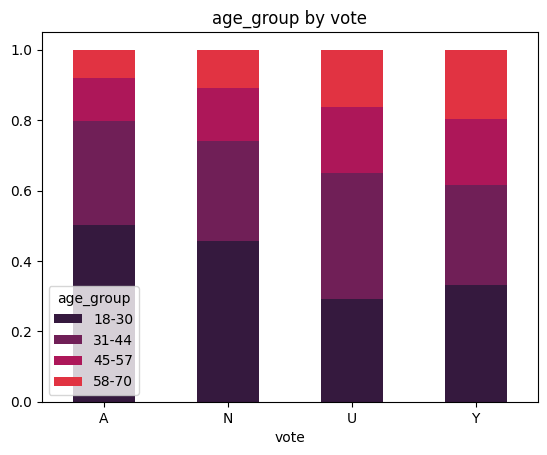

In [636]:
plot_voting_dist(df.vote, df.age_group)

<Figure size 800x500 with 0 Axes>

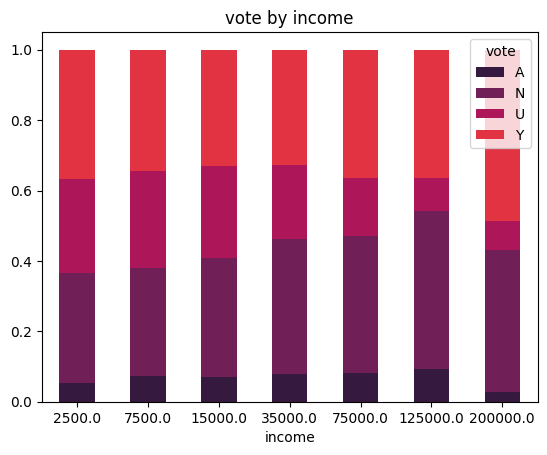

In [638]:
plot_voting_dist(df.income, df.vote)

<Figure size 800x500 with 0 Axes>

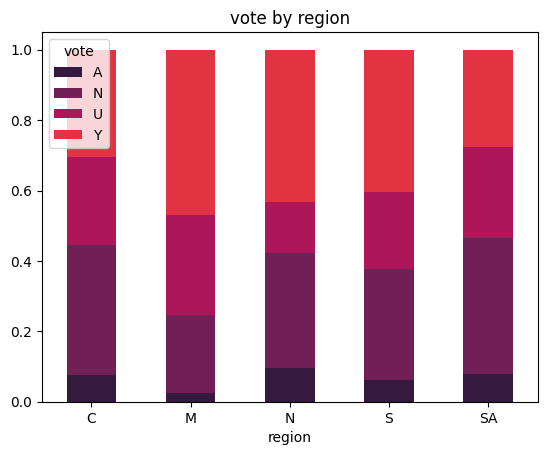

In [640]:
plot_voting_dist(df.region, df.vote)